In [1]:
# PROJECT ADDITIONAL DATA PROCESSING - GROUP 5

In [ ]:
# install all required packages
!pip install pandas matplotlib seaborn textblob spacy wordcloud gcsfs -q
# download TextBlob corpora (used for sentiment)
!python -m textblob.download_corpora
# download spaCy English model (used for NER)
!python -m spacy download en_core_web_sm

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 139.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [31]:
# IMPORT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import spacy
from wordcloud import WordCloud


In [33]:
# LOAD PARQUET DATA FROM GCS
df = pd.read_parquet('gs://big_data_news_stream/news-data/raw-articles')
df['publishedAt'] = pd.to_datetime(df['publishedAt'])
df = df.dropna(subset=['publishedAt'])
df.head()


,publishedAt,source_name,title,author,description,content,url,urlToImage
0,2025-04-20 18:39:38,ABC News,WATCH: POV: Riding into St. Peter's Square wit...,ABC News,Video provided by the Vatican shows Pope Franc...,<ul><li>El Salvador trip was to defend the rig...,https://abcnews.go.com/International/video/pov...,https://i.abcnewsfe.com/a/721c9e44-aa32-49a1-9...
1,2025-04-20 18:39:10,Rolling Out,8 Key features that make wireless bras worth it,Tega Egwabor,Modern wireless bras have undergone a complete...,Modern wireless bras have undergone a complete...,https://rollingout.com/2025/04/20/feature-that...,https://rollingout.com/wp-content/uploads/2024...
2,2025-04-20 18:37:58,Github.com,Show HN: Integrating Local Open LLMs (LLM-Jp) ...,ss-13,Article URL: https://github.com/suzuki-2001/ml...,Japanese Article of this repository\r\nThis re...,https://github.com/suzuki-2001/mlflow-llm-jp-i...,https://opengraph.githubassets.com/d3869079b6d...
3,2025-04-20 18:36:00,GlobeNewswire,XRP News: XploraDEX Nears Presale Deadline—Onl...,XploraDEX,"ZURICH, April 20, 2025 (GLOBE NEWSWIRE) -- The...","ZURICH, April 20, 2025 (GLOBE NEWSWIRE) -- The...",https://www.globenewswire.com/news-release/202...,https://ml.globenewswire.com/Resource/Download...
4,2025-04-20 18:35:11,Bringatrailer.com,24k-Mile 2006 Lexus LS430,bringatrailer,This 2006 Lexus LS430 was initially sold in Ca...,This 2006 Lexus LS430 was initially sold in Ca...,https://bringatrailer.com/listing/2006-lexus-l...,https://bringatrailer.com/wp-content/uploads/2...


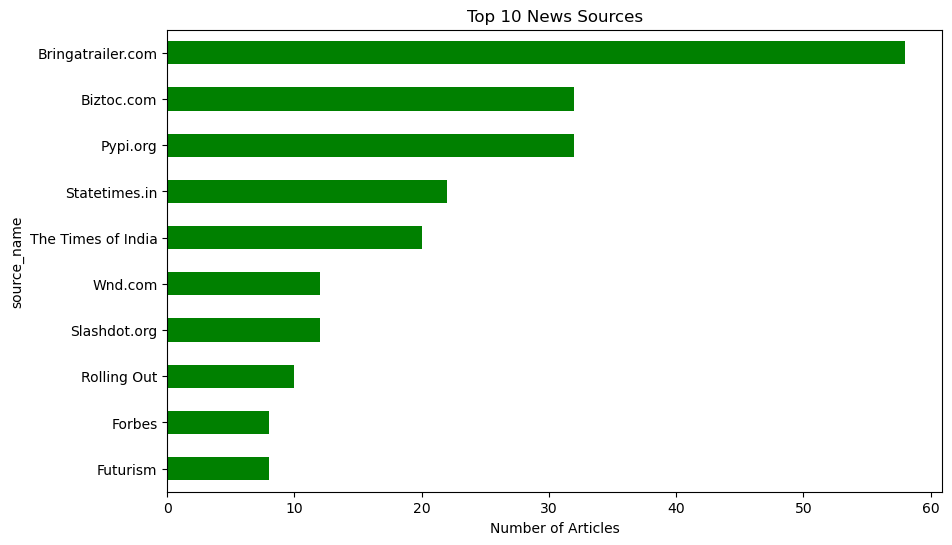

In [34]:
# TOP 10 NEWS SOURCES
plt.figure(figsize=(10, 6))
df['source_name'].value_counts().nlargest(10).plot(kind='barh', color='GREEN')
plt.title("Top 10 News Sources")
plt.xlabel("Number of Articles")
plt.gca().invert_yaxis()
plt.show()


In [36]:
# Function to classify sentiment
def classify_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment classification to title column
df['sentiment_label'] = df['title'].astype(str).apply(classify_sentiment)

# Preview a few rows
df[['title', 'sentiment_label']].sample(10)


,title,sentiment_label
126,RingCentral Video,neutral
325,Van Hollen Suggests He's OK With Deporting Abr...,positive
136,2016 Porsche Macan S at No Reserve,neutral
105,Thousands of job losses across National Health...,neutral
250,jenix added to PyPI,neutral
100,School bias complaints DOUBLED under Joe Biden,neutral
271,Van Hollen Never Reached Out About Daughter's ...,neutral
53,Trump draft executive order would make sweepin...,neutral
304,Dogecoin Price Squeezes Into Triangle With Bre...,neutral
87,18k-Mile 2007 Maserati Quattroporte Sport GT,neutral


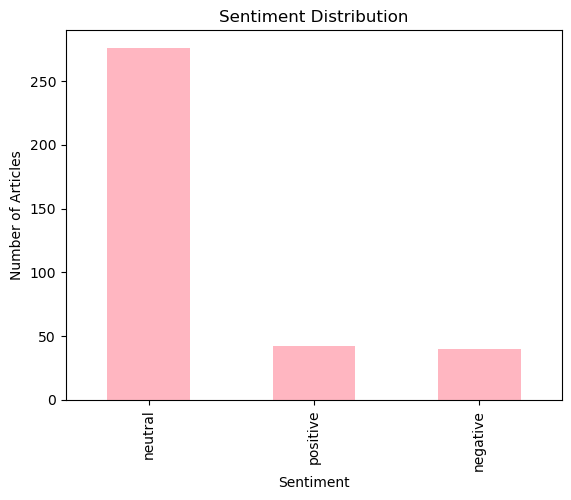

In [37]:
df['sentiment_label'].value_counts().plot(kind='bar', color='lightpink')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Articles")
plt.show()


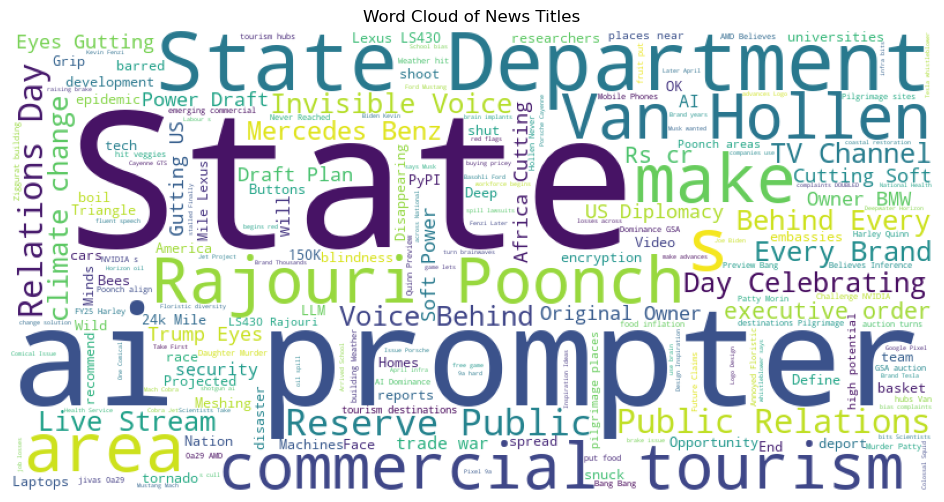

In [38]:
# WORD CLOUD FROM TITLES
text = ' '.join(df['title'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Word Cloud of News Titles")
plt.show()


In [39]:
import spacy

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Create empty lists to store entities per row
persons = []
orgs = []
locations = []

# Process each title and collect entities
for title in df['title'].fillna(''):
    doc = nlp(title)
    person_ents = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']
    org_ents = [ent.text for ent in doc.ents if ent.label_ == 'ORG']
    gpe_ents = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
    
    persons.append(", ".join(person_ents))
    orgs.append(", ".join(org_ents))
    locations.append(", ".join(gpe_ents))

# Add the new columns to your dataframe
df['persons'] = persons
df['organizations'] = orgs
df['locations'] = locations


In [40]:
df[['title', 'persons', 'organizations', 'locations']].tail(10)


,title,persons,organizations,locations
348,Delta Airlines Execs Drive Loyalty Through A B...,,Delta Airlines,
349,slidio 1.0.0,,,
350,"Trump eyes gutting US diplomacy in Africa, cut...",,,US
351,18k-Mile 2007 Maserati Quattroporte Sport GT,,,
352,Amazon makes urgent move to avoid US-China tra...,,Amazon,"US, China"
353,4/20/25 National Security and Korean News and ...,,"National Security, Korean News",
354,"5 Stocks to Buy the Dip, According to AI",Dip,,AI
355,Microsoft's BitNet shows what AI can do with j...,,"Microsoft, BitNet, MB, GPU",AI
356,Analysis: Qassem’s speech on Lebanon’s nationa...,,Hezbollah,Lebanon
357,2005 Ford Excursion Limited Power Stroke 4×4,,Ford Excursion Limited Power,


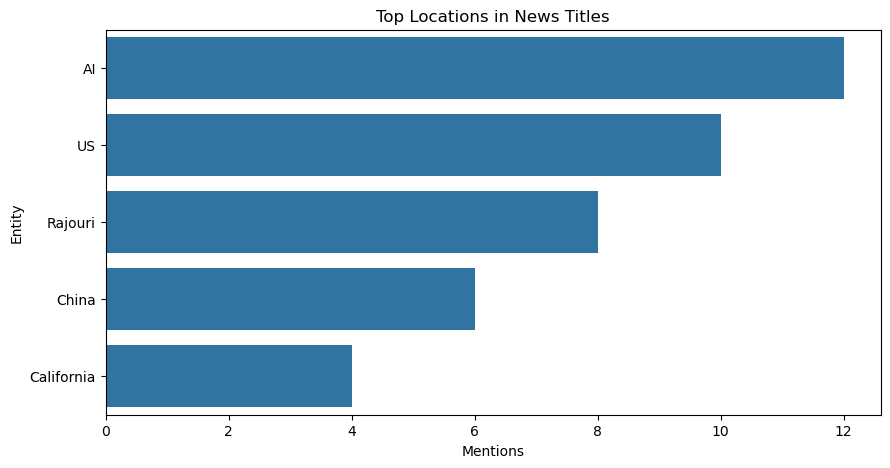

In [41]:
from collections import Counter

# Count location mentions
all_locations = [loc.strip() for sublist in df['locations'] for loc in sublist.split(",") if loc.strip()]
gpe_counter = Counter(all_locations)
top_locations = gpe_counter.most_common(5)

# Helper function to plot bar charts
def plot_top_entities(entity_list, title):
    labels, counts = zip(*entity_list)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(labels), hue=None, legend=False)
    plt.title(title)
    plt.xlabel("Mentions")
    plt.ylabel("Entity")
    plt.show()

# Visualizations
plot_top_entities(top_locations, "Top Locations in News Titles")


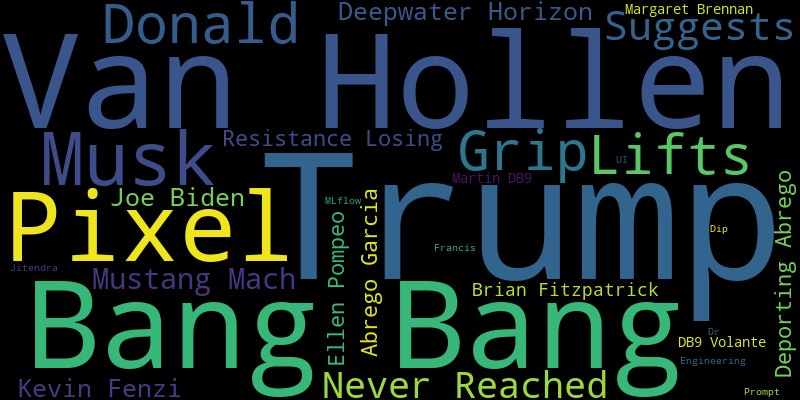

In [42]:
from collections import Counter

# Create a flat list of all person names
all_persons = [person.strip() for sublist in df['persons'] for person in sublist.split(",") if person.strip()]

# Count person name frequencies
person_counter = Counter(all_persons)

person_text = ' '.join([ent for ent in person_counter.elements()])
WordCloud(width=800, height=400).generate(person_text).to_image()

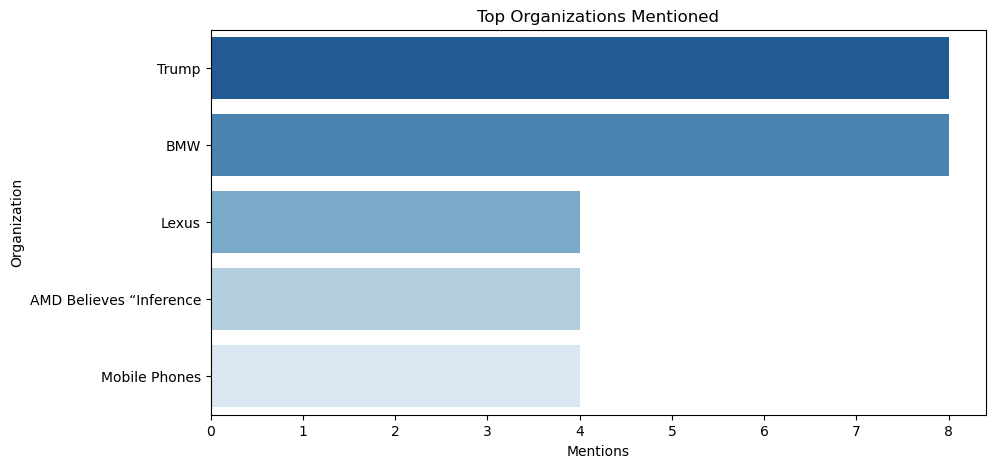

In [43]:
from collections import Counter

org_list = [org.strip() for row in df['organizations'] for org in row.split(',') if org.strip()]
top_orgs = Counter(org_list).most_common(5)

# Plot
labels, counts = zip(*top_orgs)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(counts), y=list(labels), hue=list(labels), palette='Blues_r', dodge=False, legend=False)
plt.title("Top Organizations Mentioned")
plt.xlabel("Mentions")
plt.ylabel("Organization")
plt.show()
